In [1]:
from FetalECGExtractor import FetalECGExtractor
from pipeline_functions import preprocess_signal,load_ground_truth, plot_results, debug_plot_overlay, load_and_interpolate,  calculate_snr_sir, calculate_paper_metrics, evaluate_performance, subtract_average_beat, extract_and_analyze_multichannel, plot_pipeline_stages, plot_reliability_correlations, run_ica_and_select_best
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import resample

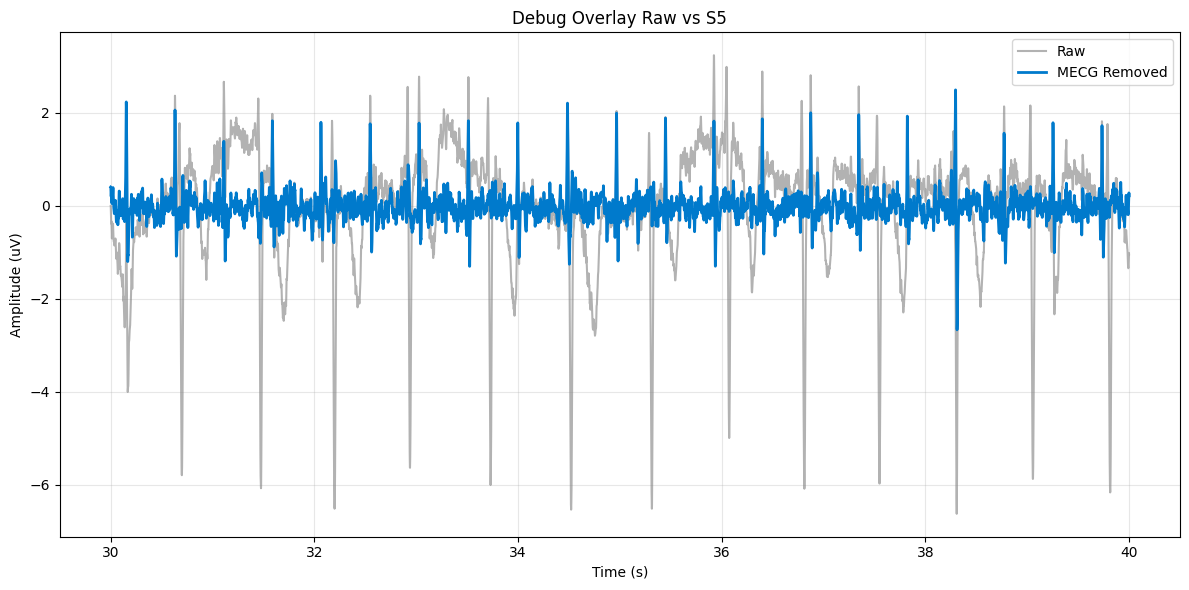

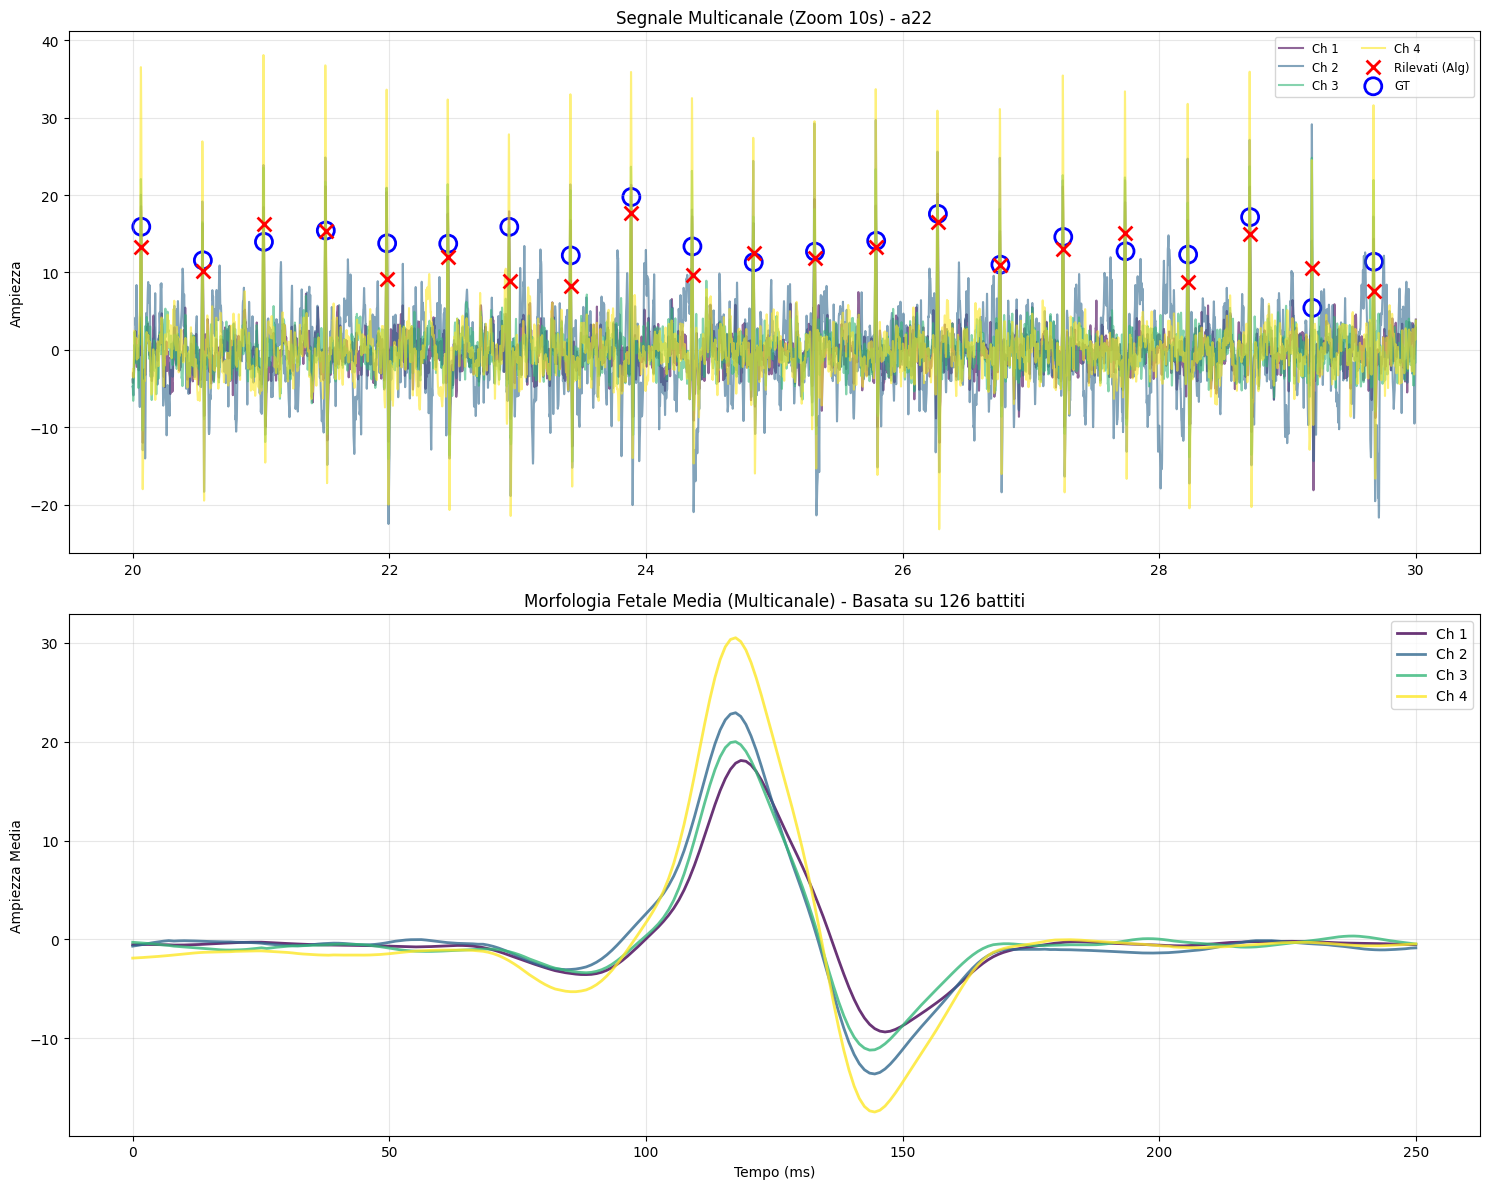

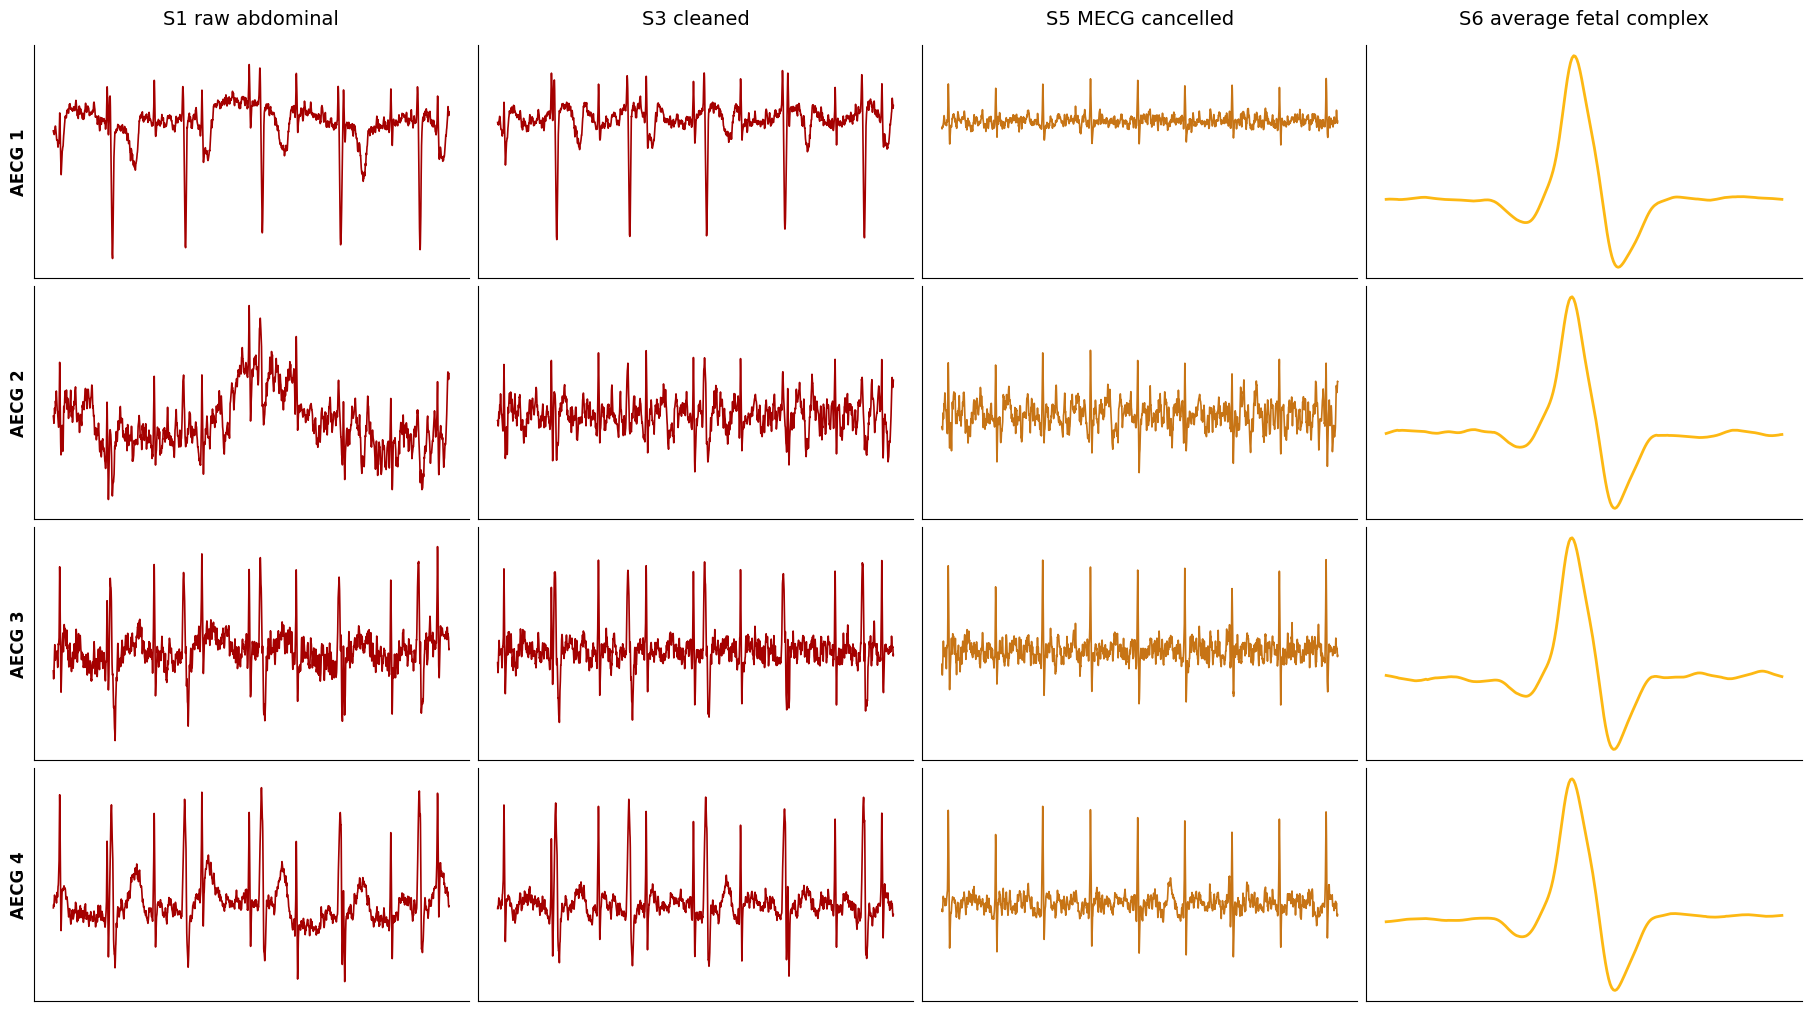

In [2]:
BASE_PATH = './data/set_a/'
record_list = [f"a{i:02d}" for i in range(1, 26)]
TARGET_FS = 2000
OUTPUT_CSV = "risultati_metriche_2.csv"

header = ['REC', 'BPM', 'Reliability', 'SNR', 'SIR', 'Accuracy', 'Se', 'PPV', 'F1']
with open(OUTPUT_CSV, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)

fetal_extractor = FetalECGExtractor(TARGET_FS)

for rec_name in record_list:
    
    full_path = os.path.join(BASE_PATH, rec_name)
    raw, fields = load_and_interpolate(full_path)
    fs_native = fields['fs']
    n_samples = raw.shape[0]
    
    S5, S4, up_factor = preprocess_signal(raw, fs_native, TARGET_FS)
    
    best_signal, S6, f_peaks = extract_and_analyze_multichannel(S5, fetal_extractor, TARGET_FS)
    
    gt_peaks, _ = load_ground_truth(full_path, n_samples, up_factor)
    
    if rec_name == "a22":
        
        debug_plot_overlay(raw, fs_native, S5, TARGET_FS, title="Debug Overlay Raw vs S5", start_s=30, duration_s=10, channel_idx=0)
        plot_results(rec_name, S5, f_peaks, gt_peaks, fetal_extractor, TARGET_FS)

        if len(raw) != len(S5):
            raw_for_plot = resample(raw, len(S5))
        else:
            raw_for_plot = raw

        plot_pipeline_stages(
            s1_raw=raw_for_plot,
            s3_cleaned=S4,
            s5_cancelled=S5,
            s6_avg_beat=S6,
            fs=TARGET_FS,
            start_sec=20,
            duration_sec=4
        )
    
    noise = subtract_average_beat(S5, f_peaks, S6)

    snr, sir = calculate_snr_sir(S4, S5, S6, noise)
    
    seg_len_up = n_samples * up_factor
    rel, bpm, success = calculate_paper_metrics(f_peaks, TARGET_FS, seg_len_up)
    performance = evaluate_performance(gt_peaks, f_peaks, TARGET_FS, tol_ms=50)
    
    with open(OUTPUT_CSV, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            rec_name, 
            f"{bpm:.2f}", 
            f"{rel:.4f}", 
            f"{snr:.2f}", 
            f"{sir:.2f}",
            f"{performance['Accuracy']:.2f}",
            f"{performance['Se']:.2f}",
            f"{performance['PPV']:.2f}",
            f"{performance['F1']:.2f}"
        ])

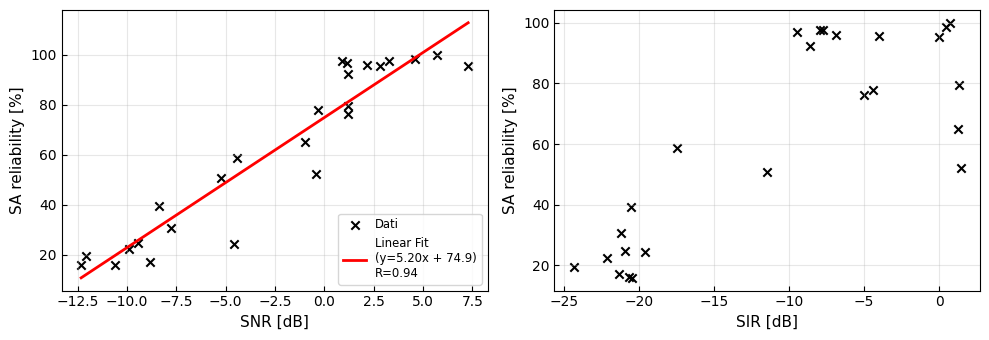

In [ ]:
def linear_func(x, m, q):
    return m * x + q

df = pd.read_csv(OUTPUT_CSV)
df['Reliability_Pct'] = df['Reliability'] * 100

df_sorted = df.sort_values(by='SNR')
x_data = df_sorted['SNR'].values
y_data = df_sorted['Reliability_Pct'].values

x_fit = []
y_fit = []
fit_label = "Fit fallito"

try:
    popt, pcov = curve_fit(linear_func, x_data, y_data)
    
    m, q = popt
    
    x_fit = np.linspace(min(x_data), max(x_data), 500)
    y_fit = linear_func(x_fit, *popt)
    
    correlation_matrix = np.corrcoef(x_data, y_data)
    r_value = correlation_matrix[0, 1]
    
    fit_label = f'Linear Fit\n(y={m:.2f}x + {q:.1f})\nR={r_value:.2f}'
    
except Exception as e:
    print(f"Errore nel fitting: {e}")

plot_reliability_correlations(df, x_fit, y_fit, fit_label)

In [4]:
corr_matrix_pearson = df[['Reliability', 'SNR', 'SIR']].corr(method='pearson')
print("\nPearson Correlation Matrix:")
print(corr_matrix_pearson)


Pearson Correlation Matrix:
             Reliability       SNR       SIR
Reliability     1.000000  0.944731  0.816044
SNR             0.944731  1.000000  0.893221
SIR             0.816044  0.893221  1.000000


In [5]:
SNRs = df['SNR'].values
SIRs = df['SIR'].values
print(f"{SNRs.mean():.2f}")
print(f"{SIRs.mean():.2f}")

-2.55
-10.76


PIPELINE WITH ICA

In [ ]:
BASE_PATH = './data/set_a/'
record_list = [f"a{i:02d}" for i in range(1, 26)]
TARGET_FS = 2000
OUTPUT_CSV = "risultati_ica_rapido.csv"

header = ['REC', 'BPM', 'Reliability']
with open(OUTPUT_CSV, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)

fetal_extractor = FetalECGExtractor(TARGET_FS)

for rec_name in record_list:
    print(f"Processing {rec_name}...")
    
    full_path = os.path.join(BASE_PATH, rec_name)
    raw, fields = load_and_interpolate(full_path)
    fs_native = fields['fs']
    
    _, S4, up_factor = preprocess_signal(raw, fs_native, TARGET_FS)
    n_samples_up = S4.shape[0]
    
    best_result = run_ica_and_select_best(S4, fetal_extractor, TARGET_FS, n_samples_up)
    
    with open(OUTPUT_CSV, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            rec_name, 
            f"{best_result['bpm']:.2f}", 
            f"{best_result['reliability']:.4f}"
        ])
        

In [ ]:
df_1 = pd.read_csv("risultati_ica_rapido.csv")
average_reliability = df_1['Reliability'].mean()
print(f"Average Reliability ICA: {average_reliability:.4f}")

df_2 = pd.read_csv("risultati_metriche.csv")
average_reliability = df_2['Reliability'].mean()
print(f"Average Reliability: {average_reliability:.4f}")

df_3 = pd.read_csv("risultati_metriche_2.csv")
average_reliability = df_3['Reliability'].mean()
print(f"Average Reliability 2: {average_reliability:.4f}")

Average Reliability ICA: 0.4931
Average Reliability: 0.6159
Average Reliability 2: 0.6171


In [ ]:
df_2_passed = df_2[df_2['Reliability'] >= 0.6]
df_2_failed = df_2[df_2['Reliability'] < 0.6]
df_3_passed = df_3[df_3['Reliability'] >= 0.6]
df_3_failed = df_3[df_3['Reliability'] < 0.6]

print(f"Set 2 - Passed: {len(df_2_passed)}, Failed: {len(df_2_failed)}")
print(f"Set 3 - Passed: {len(df_3_passed)}, Failed: {len(df_3_failed)}")

average_reliability_2_passed = df_2_passed['Reliability'].mean()
average_reliability_2_failed = df_2_failed['Reliability'].mean()

print(f"Average Reliability 2 Passed: {average_reliability_2_passed:.4f}")
print(f"Average Reliability 2 Failed: {average_reliability_2_failed:.4f}")

average_reliability_3_passed = df_3_passed['Reliability'].mean()
average_reliability_3_failed = df_3_failed['Reliability'].mean()

print(f"Average Reliability 3 Passed: {average_reliability_3_passed:.4f}")
print(f"Average Reliability 3 Failed: {average_reliability_3_failed:.4f}")

Set 2 - Passed: 13, Failed: 12
Set 3 - Passed: 14, Failed: 11
Average Reliability 2 Passed: 0.8984
Average Reliability 2 Failed: 0.3097
Average Reliability 3 Passed: 0.9197
Average Reliability 3 Failed: 0.2319


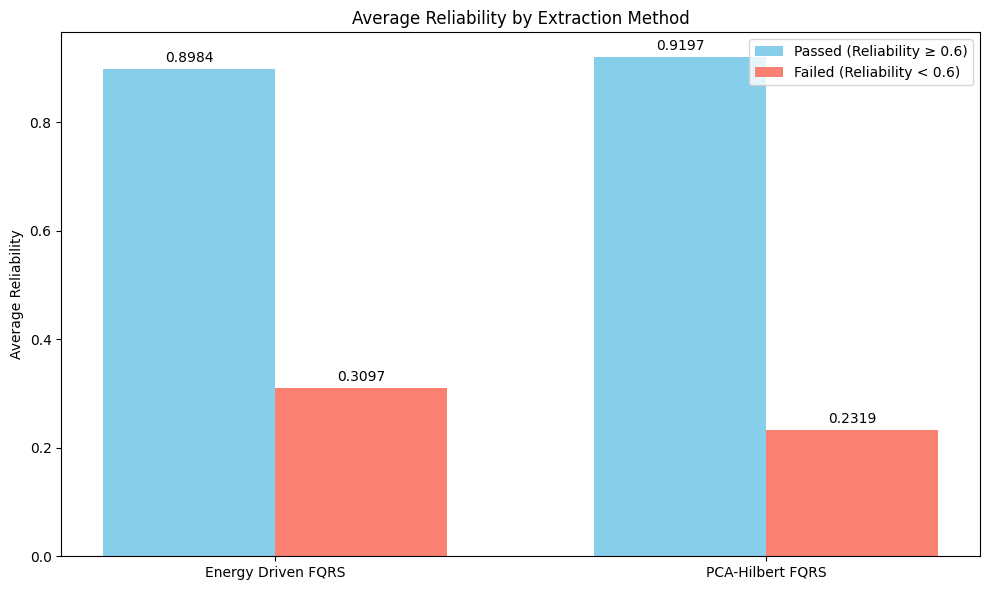

In [ ]:
df_2_passed = df_2[df_2['Reliability'] >= 0.6]
df_2_failed = df_2[df_2['Reliability'] < 0.6]
df_3_passed = df_3[df_3['Reliability'] >= 0.6]
df_3_failed = df_3[df_3['Reliability'] < 0.6]

avg_rel_2_passed = df_2_passed['Reliability'].mean()
avg_rel_2_failed = df_2_failed['Reliability'].mean()
avg_rel_3_passed = df_3_passed['Reliability'].mean()
avg_rel_3_failed = df_3_failed['Reliability'].mean()

methods = ['Energy Driven FQRS', 'PCA-Hilbert FQRS']
passed_means = [avg_rel_2_passed, avg_rel_3_passed]
failed_means = [avg_rel_2_failed, avg_rel_3_failed]

x = np.arange(len(methods))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, passed_means, width, label='Passed (Reliability ≥ 0.6)', color='skyblue')
rects2 = ax.bar(x + width/2, failed_means, width, label='Failed (Reliability < 0.6)', color='salmon')

ax.set_ylabel('Average Reliability')
ax.set_title('Average Reliability by Extraction Method')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.4f')
ax.bar_label(rects2, padding=3, fmt='%.4f')

plt.tight_layout()
plt.show()

Average Reliability ICA: 0.4931
Average Reliability Energy Driven FQRS: 0.6159
Average Reliability PCA-Hilbert FQRS: 0.6171


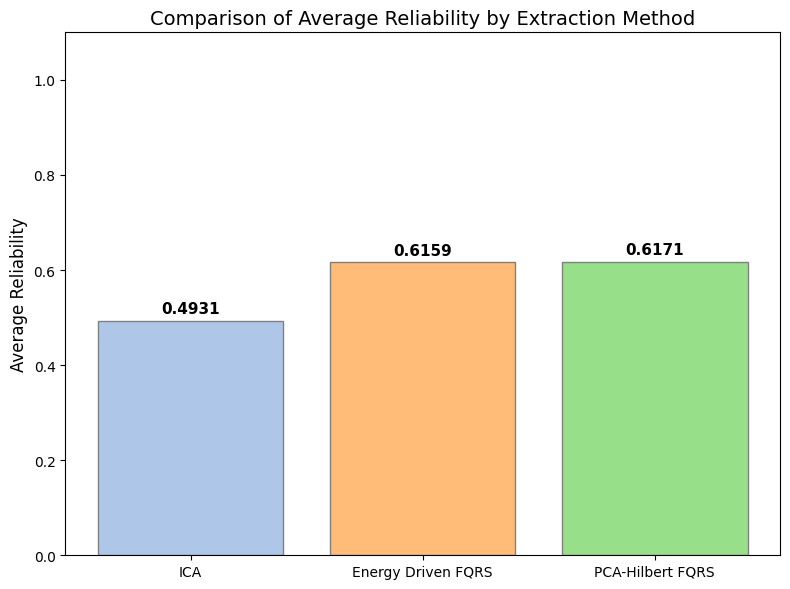

In [ ]:
try:
    df_1 = pd.read_csv("risultati_ica_rapido.csv")
    df_2 = pd.read_csv("risultati_metriche.csv")
    df_3 = pd.read_csv("risultati_metriche_2.csv")
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit()

avg_ica = df_1['Reliability'].mean()
avg_energy = df_2['Reliability'].mean()
avg_pca = df_3['Reliability'].mean()

print(f"Average Reliability ICA: {avg_ica:.4f}")
print(f"Average Reliability Energy Driven FQRS: {avg_energy:.4f}")
print(f"Average Reliability PCA-Hilbert FQRS: {avg_pca:.4f}")

methods = ['ICA', 'Energy Driven FQRS', 'PCA-Hilbert FQRS']
averages = [avg_ica, avg_energy, avg_pca]
colors = ['#aec7e8', '#ffbb78', '#98df8a']  # Soft blue, orange, green

plt.figure(figsize=(8, 6))
bars = plt.bar(methods, averages, color=colors, edgecolor='grey')

# Add titles and labels
plt.title('Comparison of Average Reliability by Extraction Method', fontsize=14)
plt.ylabel('Average Reliability', fontsize=12)
plt.ylim(0, 1.1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01,
             f'{height:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()